In [12]:
%load_ext nb_black
%load_ext autoreload
%autoreload 2

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<IPython.core.display.Javascript object>

In [13]:
import json
import os
import math
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.cluster import normalized_mutual_info_score
from mstream.mstream import Mstream

plt.style.use("ggplot")

<IPython.core.display.Javascript object>

In [14]:
DS_DIR = "data"
DS_NAMES = ["News", "News-T", "Tweets", "Tweets-T"]
DS_PATHS = [os.path.join(DS_DIR, ds_name) for ds_name in DS_NAMES]

<IPython.core.display.Javascript object>

In [15]:
def load_batches(ds_path, batch_size=int(2 ** 8)):
    with open(ds_path) as f:
        docs = []
        for line in f:
            parsed_line = json.loads(line)
            docs.append(parsed_line)
            if len(docs) == batch_size:
                yield docs
                docs = []
        if len(docs) > 0:
            yield docs

<IPython.core.display.Javascript object>

In [16]:
def transform(docs):
    return [{"id": doc["Id"], "word_list": doc["textCleaned"].split()} for doc in docs]

<IPython.core.display.Javascript object>

In [31]:
num_docs = sum([len(doc_batch) for doc_batch in load_batches(DS_PATHS[2])])
batch_size = math.ceil(num_docs / 16)
batch_size = 1
mstream = Mstream()
parsed_docs = next(load_batches(DS_PATHS[2], batch_size))
docs = transform(parsed_docs)
res = mstream.process(docs)

/home/mionut/Documentos/py-mstream/mstream/clusterfeature.py:78: RuntimeWarning: divide by zero encountered in double_scalars
  factor = 1.0 / np.sum(dist)
/home/mionut/Documentos/py-mstream/mstream/clusterfeature.py:79: RuntimeWarning: invalid value encountered in multiply
  return dist * factor


<IPython.core.display.Javascript object>

In [8]:
mstream.get_top_words(num_words_topic=2)

{0: {3: 0.002333484367920254, 18: 0.002333484367920254},
 1: {53: 0.0014459184389696064, 61: 0.0014459184389696064},
 2: {113: 0.0021898120588485404, 114: 0.0021898120588485404},
 3: {238: 0.001824203460673363, 241: 0.001824203460673363},
 4: {219: 0.0019526436520123614, 220: 0.0019526436520123614},
 5: {224: 0.0033354922279792737, 229: 0.0033354922279792737},
 6: {346: 0.0009308714945458163, 350: 0.0009308714945458163},
 7: {387: 0.002906730633554394, 388: 0.002906730633554394},
 8: {419: 0.004440995127840294, 422: 0.004440995127840294},
 9: {712: 0.0043430595378647335, 996: 0.0043430595378647335},
 10: {547: 0.0031328892538856974, 548: 0.0031328892538856974},
 11: {563: 0.004712449100974517, 565: 0.004712449100974517},
 12: {716: 0.00606417427141595, 657: 0.00606417427141595},
 13: {246: 0.005957889865802871, 1016: 0.005957889865802871},
 14: {803: 0.0028045526330120365, 538: 0.0028045526330120365},
 15: {976: 0.006536362482548544, 977: 0.006536362482548544},
 16: {403: 0.00943050723

<IPython.core.display.Javascript object>

Caculate the NMI for each batch

In [67]:
num_batches = 16
num_total_docs = sum([len(doc_batch) for doc_batch in load_batches(DS_PATHS[2])])
batch_size = math.ceil(num_total_docs / num_batches)
mstream = Mstream()
nmis = []
for parsed_docs in load_batches(DS_PATHS[2], batch_size):
    docs = transform(parsed_docs)
    nmi = normalized_mutual_info_score(
        [doc["clusterNo"] for doc in parsed_docs], mstream.process(docs)
    )
    nmis.append(nmi)

<IPython.core.display.Javascript object>

ValueError: x and y must have same first dimension, but have shapes (16,) and (10,)

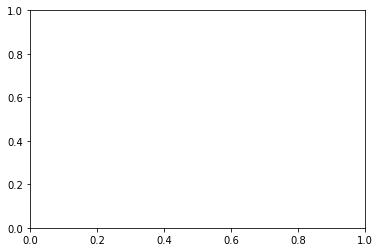

<IPython.core.display.Javascript object>

In [72]:
plt.plot(range(1, num_batches + 1), nmis)
plt.ylabel("NMI")
plt.xlabel("Batch number")
plt.title("NMI for each batch")
plt.show()

Calculate the NMI as a function of the number of iterations

In [11]:
num_batches = 16
max_num_iter = 11
num_iters = list(range(1, max_num_iter))
ds_nmis = []
for ds_path in DS_PATHS:
    num_total_docs = sum([len(batch) for batch in load_batches(ds_path)])
    batch_size = math.ceil(num_total_docs / num_batches)
    batch_size = 1
    nmis = []
    for num_iter in num_iters:
        mstream = Mstream(num_iter)
        y_hat = []
        y = []
        for parsed_docs in load_batches(ds_path, batch_size):
            y += [doc["clusterNo"] for doc in parsed_docs]
            y_hat += mstream.process(transform(parsed_docs))
        nmi = normalized_mutual_info_score(y, y_hat)
        nmis.append(nmi)
    ds_nmis.append(nmis)

KeyboardInterrupt: 

<IPython.core.display.Javascript object>

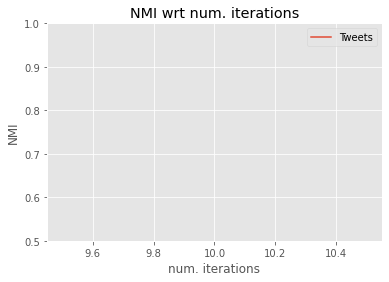

<IPython.core.display.Javascript object>

In [30]:
fig, ax = plt.subplots()
ax.set_title("NMI wrt num. iterations")
ax.set_xlabel("num. iterations")
ax.set_ylabel("NMI")
# ax.set_yticks(np.arange(0.5, 1.1, step=0.1))
ax.set_ylim(0.5, 1)
for i, ds_nmi in enumerate(ds_nmis):
    ax.plot(num_iters, ds_nmi, label=DS_NAMES[i])
ax.legend()